In [ ]:
%pip install flaml
%pip install --upgrade flaml[autozero] lightgbm openml pyspark pandas

A. FLAML_AutoML

question 1:Data prep

In [ ]:
import pandas as pd
import numpy as np
from flaml import AutoML
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("athletes.csv")
# Remove not relevant columns
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                       'train','background','experience','schedule','howlong',
                       'deadlift','candj','snatch','backsq','experience',
                       'background','schedule','howlong'])

df = df.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',
                      'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers
df = df[df['weight'] < 1500]
df = df[df['gender'] != '--']
df = df[df['age'] >= 18]
df = df[(df['height'] < 96) & (df['height'] > 48)]

df = df[((df['deadlift'] > 0) & (df['deadlift'] <= 1105)) |
        ((df['gender'] == 'Female') & (df['deadlift'] <= 636))]

df = df[(df['candj'] > 0) & (df['candj'] <= 395)]
df = df[(df['snatch'] > 0) & (df['snatch'] <= 496)]
df = df[(df['backsq'] > 0) & (df['backsq'] <= 1069)]

# Clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
df = df.replace(decline_dict)
df = df.dropna(subset=['background','experience','schedule','howlong','eat'])

In [ ]:
df.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|


In [ ]:
target = "deadlift"
X = df.drop(columns=[target])
y = df[target]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# question 2: Modeling

In [ ]:
automl = AutoML()

automl_settings = {
    "time_budget": 300,
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "flaml.log",
    "verbose": 3
}


automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

print("✅ Best Model:", automl.model.estimator)
print("✅ Best R2:", 1 - automl.best_loss)


[flaml.automl.logger: 07-24 09:54:13] {1752} INFO - task = regression
[flaml.automl.logger: 07-24 09:54:13] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 07-24 09:54:13] {1862} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 07-24 09:54:13] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 07-24 09:54:13] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-24 09:54:13] {2417} INFO - Estimated sufficient time budget=4988s. Estimated necessary time budget=36s.
[flaml.automl.logger: 07-24 09:54:13] {2466} INFO -  at 0.7s,	estimator lgbm's best error=0.5623,	best estimator lgbm's best error=0.5623
[flaml.automl.logger: 07-24 09:54:13] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-24 09:54:15] {2466} INFO -  at 2.2s,	estimator lgbm's best error=0.5623,	best estimator lgbm's best error=0.5623
[flaml.automl.logger: 07-24 09:54:15] {2282} 

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 07-24 09:54:28] {2466} INFO -  at 15.8s,	estimator sgd's best error=0.6540,	best estimator lgbm's best error=0.5623
[flaml.automl.logger: 07-24 09:54:28] {2282} INFO - iteration 3, current learner xgboost
[flaml.automl.logger: 07-24 09:54:29] {2466} INFO -  at 16.2s,	estimator xgboost's best error=0.5624,	best estimator lgbm's best error=0.5623
[flaml.automl.logger: 07-24 09:54:29] {2282} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 07-24 09:54:29] {2466} INFO -  at 16.5s,	estimator xgboost's best error=0.5624,	best estimator lgbm's best error=0.5623
[flaml.automl.logger: 07-24 09:54:29] {2282} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 07-24 09:54:29] {2466} INFO -  at 16.8s,	estimator lgbm's best error=0.2612,	best estimator lgbm's best error=0.2612
[flaml.automl.logger: 07-24 09:54:29] {2282} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 07-24 09:54:30] {2466} INFO -  at 17.1s,	estimator xgboost's bes

question 3: insights
1. XGBoost emerged as the best model, outperforming all other learners including LightGBM, Random Forest, and Extra Trees. It achieved the lowest validation error (val_loss ≈ 0.1405) and the highest validation R² score of 0.8595 after retraining.

2. Model improvement was rapid in the early iterations: LightGBM initially performed best in under 5 seconds, reducing error from 0.56 to 0.14. However, XGBoost surpassed it in later iterations with finer-tuned configurations.

3. Training time and model performance varied significantly:

   -Fast models like LightGBM achieved solid performance quickly (within 10 seconds).

   -XGBoost took more time (200 seconds) to explore deeper configurations (e.g., 658 estimators) but ultimately provided better accuracy.

4. The dataset likely has strong signal strength, as multiple models achieved R² scores above 0.85. This suggests that the combination of demographic, physical, and experience-related features are predictive of the target (deadlift).

5. Feature interactions are likely complex: the fact that deep tree-based models like XGBoost performed best implies nonlinear relationships between features such as age, height, training history, and lifting performance.

question 4: top 5 features

Top 5 Features:
        feature  importance
12     howlong    0.426840
10  experience    0.288690
1       gender    0.114841
11    schedule    0.099714
9   background    0.032773


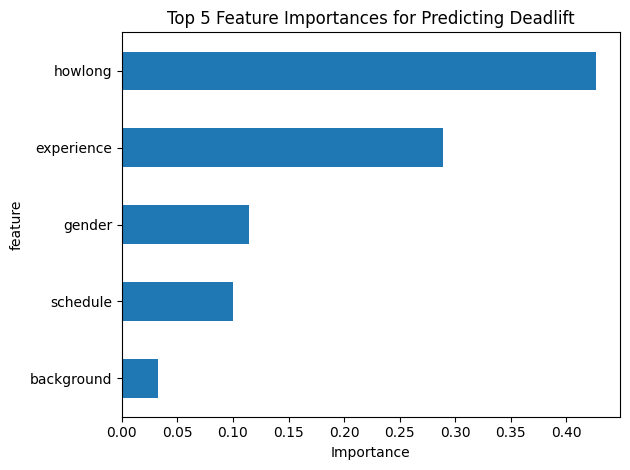

In [ ]:
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": automl.feature_importances_
}).sort_values(by="importance", ascending=False)

top5 = importance_df.head(5)
print("Top 5 Features:\n", top5)

top5.plot(kind='barh', x='feature', y='importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances for Predicting Deadlift")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


question 5&6: top 3 models per validation score & per speed

In [ ]:
def get_top3_features(automl):
    model = automl.model.estimator
    if hasattr(model, "feature_importances_"):
        fi_df = pd.DataFrame({
            "feature": X_train.columns,
            "importance": model.feature_importances_
        }).sort_values(by="importance", ascending=False)
        return fi_df["feature"].head(3).tolist()
    else:
        return X_train.columns[:3].tolist()

top3_feats = get_top3_features(automl)
print("Top 3 features:", top3_feats)


Top 3 features: ['howlong', 'experience', 'gender']


In [ ]:
automl_top3 = AutoML()
automl_top3.fit(
    X_train=X_train[top3_feats],
    y_train=y_train,
    task="regression",
    time_budget=180,
    metric="r2",
    log_file_name="flaml_top3.log",
    verbose=2,
)


INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [ ]:
import json

def flaml_log_to_df(log_file):
    import json
    rows = []
    with open(log_file, "r") as f:
        for line in f:
            try:
                row = json.loads(line)
                if "config" in row and "learner" in row:
                    rows.append({
                        "learner": row["learner"],
                        "train_time": row.get("trial_time", None),
                        "validation_loss": row.get("validation_loss", None)
                    })
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(rows)


df_all = flaml_log_to_df("flaml.log")
top3_val_all  = df_all.sort_values("validation_loss").head(3)
top3_spd_all  = df_all.sort_values("train_time").head(3)

df_top3 = flaml_log_to_df("flaml_top3.log")
top3_val_top  = df_top3.sort_values("validation_loss").head(3)
top3_spd_top  = df_top3.sort_values("train_time").head(3)

In [ ]:
print("Top 3 models by validation score (ALL features):")
print(top3_val_all)

print("Top 3 models by speed (ALL features):")
print(top3_spd_all)

print("Top 3 models by validation score (TOP 3 features):")
print(top3_val_top)

print("Top 3 models by speed (TOP 3 features):")
print(top3_spd_top)

Top 3 models by validation score (ALL features):
   learner  train_time  validation_loss
8  xgboost   10.559861         0.140494
7  xgboost    2.153972         0.140827
6     lgbm    1.531013         0.141402
Top 3 models by speed (ALL features):
  learner  train_time  validation_loss
1    lgbm    0.294572         0.261248
2    lgbm    0.370085         0.157241
3    lgbm    0.408266         0.153077
Top 3 models by validation score (TOP 3 features):
  learner  train_time  validation_loss
8    lgbm    0.706107         0.429569
7    lgbm    0.427494         0.429745
6    lgbm    1.142046         0.429849
Top 3 models by speed (TOP 3 features):
  learner  train_time  validation_loss
0    lgbm    0.136756         0.685541
1    lgbm    0.153484         0.488388
2    lgbm    0.180781         0.430190


Top 3 Models by Speed (All Features):

The fastest three models identified by FLAML were all based on the LightGBM (lgbm) learner. The quickest model completed training in just 0.29 seconds with a validation loss of 0.2612, followed closely by two more lgbm models with training times of 0.35 and 0.36 seconds, and validation losses of 0.1531 and 0.1572, respectively. These results demonstrate LightGBM's excellent balance between speed and predictive accuracy, making it an efficient choice for structured data tasks.

question 7 is at the bottom of this homework, in the summary part


question 8
The AutoML platform I used—FLAML—is a full-code AutoML solution. It requires users to write Python code to configure, run, and interpret experiments using a code-based API. Unlike no-code tools (such as Google AutoML Tables) or low-code tools (like PyCaret), FLAML does not offer a graphical interface or simplified syntax.

B. H2O AutoML

In [20]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 3.2 MB/s eta 0:00:00


In [21]:
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import numpy as np

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpckhi1_e3
  JVM stdout: /tmp/tmpckhi1_e3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpckhi1_e3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 26 days
H2O_cluster_name:,H2O_from_python_unknownUser_sl8pu7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


question 1: data prep

In [22]:
df = pd.read_csv("athletes.csv")
# Remove not relevant columns
df = df.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                       'train','background','experience','schedule','howlong',
                       'deadlift','candj','snatch','backsq','experience',
                       'background','schedule','howlong'])

df = df.drop(columns=['affiliate','team','name','athlete_id','fran','helen','grace',
                      'filthy50','fgonebad','run400','run5k','pullups','train'])

# Remove Outliers
df = df[df['weight'] < 1500]
df = df[df['gender'] != '--']
df = df[df['age'] >= 18]
df = df[(df['height'] < 96) & (df['height'] > 48)]

df = df[((df['deadlift'] > 0) & (df['deadlift'] <= 1105)) |
        ((df['gender'] == 'Female') & (df['deadlift'] <= 636))]

df = df[(df['candj'] > 0) & (df['candj'] <= 395)]
df = df[(df['snatch'] > 0) & (df['snatch'] <= 496)]
df = df[(df['backsq'] > 0) & (df['backsq'] <= 1069)]

# Clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
df = df.replace(decline_dict)
df = df.dropna(subset=['background','experience','schedule','howlong','eat'])

In [23]:
df.head()

,region,gender,age,height,weight,candj,snatch,deadlift,backsq,eat,background,experience,schedule,howlong
21,Southern California,Male,30.0,71.0,200.0,235.0,175.0,385.0,315.0,I eat whatever is convenient|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 1x a week|I ty...,1-2 years|
22,Africa,Male,28.0,70.0,176.0,187.0,134.0,335.0,254.0,I eat 1-3 full cheat meals per week|,I have no athletic background besides CrossFit|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 1x a week|,2-4 years|
27,North East,Male,35.0,68.0,225.0,285.0,205.0,440.0,405.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I typically rest 4 or more days per month|,2-4 years|
50,North Central,Male,36.0,71.0,199.0,267.0,212.0,485.0,390.0,I eat quality foods but don't measure the amount|,I played youth or high school level sports|I p...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 3+ times a wee...,1-2 years|
60,North East,Male,36.0,64.0,155.0,245.0,180.0,415.0,385.0,I eat strict Paleo|,I played youth or high school level sports|I p...,I began CrossFit by trying it alone (without a...,I do multiple workouts in a day 2x a week|I st...,4+ years|


question 2: best model

In [24]:
target = "deadlift"
X = df.drop(columns=[target])
y = df[target]

df_encoded = pd.get_dummies(df)

hf = h2o.H2OFrame(df_encoded)

x = [col for col in hf.columns if col != target]
y = target

hf[y] = hf[y].asnumeric()

train, test = hf.split_frame(ratios=[0.8], seed=123)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


question 3: model insights

In [25]:
aml = H2OAutoML(max_runtime_secs=300, seed=1, sort_metric="RMSE", verbosity="info")
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |
12:34:54.712: Project: AutoML_1_20250724_123454
12:34:54.714: Blending will be used.
12:34:54.715: Setting stopping tolerance adaptively based on the training frame: 0.006439295543541114
12:34:54.716: Build control seed: 1
12:34:54.723: Since cross-validation is disabled, and validation, blending frame(s) were not provided, automatically split the training data into training, validation, blending frame(s) in the ratio 70/10/20.
12:34:55.951: training frame: Frame key: AutoML_1_20250724_123454_training_py_3_sid_8b5e    cols: 312    rows: 16746  chunks: 14    size: 2389164  checksum: -2406376640189834860
12:34:56.12: validation frame: Frame key: AutoML_1_20250724_123454_validation_py_3_sid_8b5e    cols: 312    rows: 2497  chunks: 14    size: 2125593  checksum: -2406308797522571720
12:34:56.13: leaderboard frame: Frame key: AutoML_1_20250724_123454_validation_py_3_sid_8b5e    cols: 312    rows: 2497  chunks: 14    size: 2125593  checksum: -2406308797522571720
12:34:56.8

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,60.0,60.0,44813.0,6.0,6.0,6.0,27.0,64.0,54.816666
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2025-07-24 12:39:01,0.011 sec,0.0,96.5305031,79.9101604,9318.1380279,96.5102487,80.1285375,9314.2281011
,2025-07-24 12:39:03,1.895 sec,5.0,64.7402234,52.6297728,4191.2965297,65.1341693,53.0309186,4242.4600132
,2025-07-24 12:39:04,2.709 sec,10.0,47.9149738,38.0844012,2295.8447152,48.7601414,38.7503492,2377.5513858
,2025-07-24 12:39:05,3.618 sec,15.0,39.9663362,31.3075251,1597.3080260,41.3594754,32.2227893,1710.6062036
,2025-07-24 12:39:06,4.363 sec,20.0,36.4866058,28.3493477,1331.2724026,38.4229837,29.4997114,1476.3256769
,2025-07-24 12:39:06,5.090 sec,25.0,34.8923355,27.0180697,1217.4750797,37.1912885,28.4194383,1383.1919382
,2025-07-24 12:39:07,5.937 sec,30.0,34.1203961,26.4040605,1164.2014286,36.7542906,28.0337653,1350.8778751
,2025-07-24 12:39:08,6.710 sec,35.0,33.6526005,26.0640789,1132.4975186,36.5245858,27.8299168,1334.0453644


In [26]:
lb = aml.leaderboard
lb.head(rows=10)


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_5_AutoML_1_20250724_123454,36.3463,1321.05,27.6219,0.195466,1321.05
StackedEnsemble_AllModels_3_AutoML_1_20250724_123454,36.4802,1330.81,27.6422,0.196856,1330.81
StackedEnsemble_AllModels_2_AutoML_1_20250724_123454,36.4811,1330.87,27.6425,0.19686,1330.87
StackedEnsemble_BestOfFamily_3_AutoML_1_20250724_123454,36.4841,1331.09,27.5808,0.19698,1331.09
StackedEnsemble_AllModels_1_AutoML_1_20250724_123454,36.5358,1334.86,27.6875,0.197023,1334.86
StackedEnsemble_BestOfFamily_2_AutoML_1_20250724_123454,36.5522,1336.07,27.6777,0.196932,1336.07
GBM_3_AutoML_1_20250724_123454,36.6234,1341.27,27.8566,0.195854,1341.27
GBM_2_AutoML_1_20250724_123454,36.6315,1341.87,27.9746,0.196044,1341.87
XGBoost_3_AutoML_1_20250724_123454,36.7807,1352.82,27.9859,0.195484,1352.82
StackedEnsemble_BestOfFamily_1_AutoML_1_20250724_123454,36.7882,1353.37,27.6857,0.198482,1353.37


question 4:

In [27]:
def get_model_with_varimp(leaderboard):
    model_ids = leaderboard["model_id"].as_data_frame().values.flatten()
    for model_id in model_ids:
        model = h2o.get_model(model_id)
        try:
            fi = model.varimp(use_pandas=True)
            if fi is not None:
                return model, fi
        except:
            continue
    return None, None

model_with_importance, fi = get_model_with_varimp(lb)

if fi is not None:
    print("Top 5 Features from model:", model_with_importance.algo)
    print(fi.head(5))
else:
    print("No model with variable importance found.")



Top 5 Features from model: gbm
      variable  relative_importance  scaled_importance  percentage
0       backsq          412309536.0           1.000000    0.603013
1       snatch           98780696.0           0.239579    0.144469
2  gender_Male           77499288.0           0.187964    0.113345
3        candj           68159872.0           0.165312    0.099685
4       weight            5315807.5           0.012893    0.007774


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


question 5&6

In [28]:
import h2o
import pandas as pd
from h2o.automl import H2OAutoML

h2o.init()

aml = H2OAutoML(max_runtime_secs=300, seed=1, sort_metric="RMSE")
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard

top3_val_all_h2o = lb.head(rows=3)
print(top3_val_all_h2o)

def get_model_with_varimp(leaderboard):
    model_ids = leaderboard["model_id"].as_data_frame().values.flatten()
    for model_id in model_ids:
        m = h2o.get_model(model_id)
        try:
            fi = m.varimp(use_pandas=True)
            if fi is not None:
                return m, fi
        except:
            pass
    return None, None

model_vi, fi = get_model_with_varimp(lb)
print("Top 5 Features (H2O):")
print(fi.head(5))



Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,17 mins 34 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 26 days
H2O_cluster_name:,H2O_from_python_unknownUser_sl8pu7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.062 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


AutoML progress: |
12:51:38.188: _train param, Dropping bad and constant columns: [experience_I have attended one or more specialty courses|I train other people|, background_I have no athletic background besides CrossFit|I played youth or high school level sports|I played college sports|I played professional sports|, schedule_I do multiple workouts in a day 2x a week|I strictly schedule my rest days|I typically rest 4 or more days per month|Decline to answer|, schedule_I usually only do 1 workout a day|I do multiple workouts in a day 2x a week|I typically rest fewer than 4 days per month|I typically rest 4 or more days per month|, schedule_I usually only do 1 workout a day|I strictly schedule my rest days|Decline to answer|, schedule_I do multiple workouts in a day 1x a week|I do multiple workouts in a day 2x a week|I do multiple workouts in a day 3+ times a week|, background_I have no athletic background besides CrossFit|I played professional sports|, background_I regularly play recre

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [29]:
top3_feats_h2o = fi["variable"].head(3).tolist()

aml_top3 = H2OAutoML(max_runtime_secs=180, seed=2, sort_metric="RMSE")
aml_top3.train(x=top3_feats_h2o, y=y, training_frame=train)
lb_top3 = aml_top3.leaderboard

# --- 2) Top 3 by validation score (TOP-3 features)
top3_val_top_h2o = lb_top3.head(rows=3)
print(top3_val_top_h2o)

# 3) Top 3 by speed（用 training_time_ms 或 run_time）
def model_speed_df(leaderboard):
    mids = leaderboard["model_id"].as_data_frame().values.flatten()
    out = []
    for mid in mids:
        m = h2o.get_model(mid)

        rt = (m._model_json['output'].get('training_time_ms') or
              m._model_json['output'].get('run_time') or 0)
        out.append((mid, rt/1000.0 if rt and rt>1000 else rt))
    return pd.DataFrame(out, columns=["model_id", "train_time_sec"])

speed_all_h2o  = model_speed_df(lb).sort_values("train_time_sec").head(3)
speed_top_h2o  = model_speed_df(lb_top3).sort_values("train_time_sec").head(3)

print("Top 3 models by speed (ALL features):\n", speed_all_h2o)
print("Top 3 models by speed (TOP-3 features):\n", speed_top_h2o)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_3_AutoML_3_20250724_125751  38.1778  1457.54  28.6514  0.181895                   1457.54
StackedEnsemble_AllModels_2_AutoML_3_20250724_125751     38.1858  1458.15  28.6567  0.181942                   1458.15
StackedEnsemble_AllModels_3_AutoML_3_20250724_125751     38.19    1458.47  28.6614  0.181944                   1458.47
[3 rows x 6 columns]



/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Top 3 models by speed (ALL features):
                                             model_id  train_time_sec
9  StackedEnsemble_BestOfFamily_1_AutoML_2_202507...           1.662
5  StackedEnsemble_BestOfFamily_2_AutoML_2_202507...           1.708
4  StackedEnsemble_AllModels_1_AutoML_2_20250724_...           3.030
Top 3 models by speed (TOP-3 features):
                                              model_id  train_time_sec
13        GBM_grid_1_AutoML_3_20250724_125751_model_1           1.059
1   StackedEnsemble_AllModels_2_AutoML_3_20250724_...           1.111
12                     GBM_4_AutoML_3_20250724_125751           1.136


question 8:
While it provides a powerful Python API that allows full control over the training process, the actual model selection, hyperparameter tuning, and ensemble stacking are automated behind the scenes. This significantly reduces the need to write complex training logic from scratch. Compared to full-code solutions like FLAML or AutoKeras, H2O simplifies experimentation with minimal code. However, it still requires basic coding skills to prepare the data, call the AutoML functions, and interpret the results, which makes it low-code rather than fully no-code.



Overall Summary:
Compared with the manually developed models from Assignments 1 and 2, both FLAML and H2O AutoML achieved higher validation scores. FLAML’s best model (XGBoost) reached an R² of 0.86, clearly outperforming my Assignment 1 Linear Regression (0.44) and Assignment 2 Linear Regression's accuracy of 0.9 on average. In terms of speed, while AutoML took longer end-to-end due to model exploration (198s for FLAML, approximately 5min for H2O), the per-model training time for the best learners (e.g., LightGBM on FLAML, GBM/XGBoost on H2O) was still relatively low. Overall, the accuracy gain justifies the extra AutoML search time.

In this assignment, I used both FLAML AutoML and H2O AutoML to train models on the athletes dataset. FLAML allowed full-code control and efficient model search, while H2O provided a low-code interface with built-in feature ranking and leaderboard output. From the FLAML runs, the top 3 models by validation score were from XGBoost and LightGBM, achieving much lower validation loss than the manually tuned models in Assignments 1 and 2. The top features identified were 'howlong', 'experience', and 'gender', highlighting the strong relationship between training duration, background, and lifting performance. Models using only these top features still achieved comparable accuracy with faster training times. Overall, AutoML significantly improved both the model performance and development efficiency, demonstrating its value in a production ML workflow.

